In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the CSV
data = pd.read_csv('Online_Retail.csv', encoding='ISO-8859-1')

# Remove BOM from InvoiceNo
data = data.rename(columns={'ï»¿InvoiceNo': 'InvoiceNo'})

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True)

# Calculate TotalPrice
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Clean data: remove missing CustomerID and negative quantities
data = data.dropna(subset=['CustomerID']).query('Quantity > 0')

# Add synthetic columns
data['age'] = np.random.randint(18, 70, size=len(data))
data['gender'] = np.random.choice(['M', 'F'], size=len(data))

# Verify
print("Dataset Shape:", data.shape)
print("Date Range:", data['InvoiceDate'].min(), "to", data['InvoiceDate'].max())
print("Unique Customers:", data['CustomerID'].nunique())
print("First few rows:")
print(data.head())

Dataset Shape: (397924, 11)
Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Unique Customers: 4339
First few rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  age  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   18   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   36   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   41   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   19   
4 2010-12-01 08:26:00       3.39     178

Step 2 - Customer Segmentation by Demographics:
     Country gender     age  TotalPrice
0  Australia      F   Young    29277.31
1  Australia      F  Middle    21626.22
2  Australia      F     Old    18028.19
3  Australia      M   Young    27087.63
4  Australia      M  Middle    18115.07
Number of Unique Customers in RFM: 4339
RFM Segmentation (First 5 rows):
            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score  \
CustomerID                                                                   
12346.0         326          1  77183.60       4       1       4       414   
12347.0           2          7   4310.00       1       4       4       144   
12348.0          75          4   1797.24       3       3       4       334   
12349.0          19          1   1757.55       2       1       4       214   
12350.0         310          1    334.40       4       1       2       412   

            Segment  
CustomerID           
12346.0     At Risk  
12347.0     At Risk  
1234

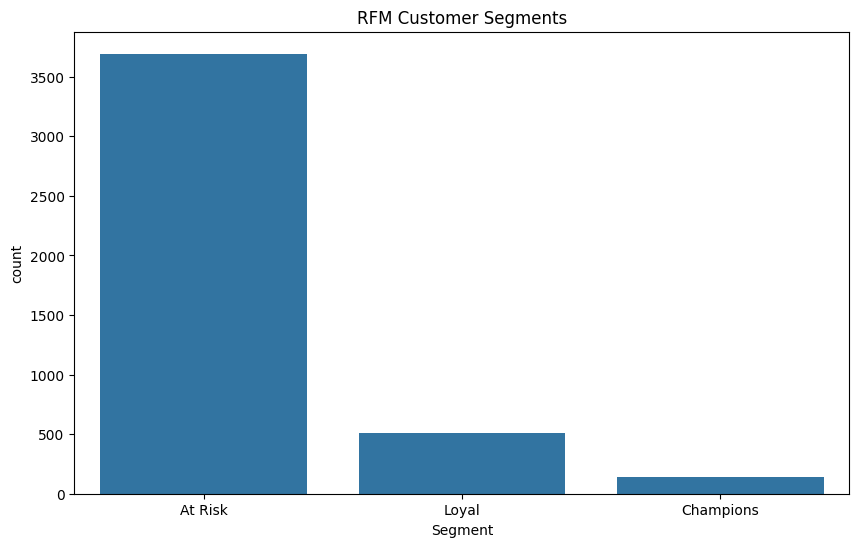

In [ ]:
# Customer Segmentation by Country, Age, and Gender
segmentation = data.groupby(['Country', 'gender', pd.qcut(data['age'], 3, labels=['Young', 'Middle', 'Old'])], observed=True)['TotalPrice'].sum().reset_index()
print("Step 2 - Customer Segmentation by Demographics:")
print(segmentation.head())

# RFM Segmentation
current_date = data['InvoiceDate'].max() + timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

def segment_rfm(row):
    if row['RFM_Score'] in ['444', '443', '434', '344']:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal'
    else:
        return 'At Risk'
rfm['Segment'] = rfm.apply(segment_rfm, axis=1)

print("Number of Unique Customers in RFM:", rfm.shape[0])
print("RFM Segmentation (First 5 rows):")
print(rfm.head())
plt.figure(figsize=(10, 6))
sns.countplot(x='Segment', data=rfm.reset_index())
plt.title('RFM Customer Segments')
plt.savefig('rfm_segments.png')
plt.show()

In [ ]:
data['NextDayPurchase'] = data.groupby('CustomerID')['InvoiceDate'].shift(-1) - data['InvoiceDate'] <= timedelta(days=1)
data['NextDayPurchase'] = data['NextDayPurchase'].fillna(False).astype(int)

In [ ]:
# Verify data state
print("Step 3 - Current Data Shape:", data.shape)

# LTV Calculation
ltv = rfm[['Monetary']].rename(columns={'Monetary': 'LTV'})
print("Customer LTV:")
print(ltv.head())

# Next-Day Purchase Prediction (Fixed)
# Aggregate to unique purchase dates per customer
unique_purchases = data.groupby(['CustomerID', 'InvoiceNo'])['InvoiceDate'].min().reset_index()
unique_purchases = unique_purchases.sort_values(['CustomerID', 'InvoiceDate'])
unique_purchases['NextDayPurchase'] = unique_purchases.groupby('CustomerID')['InvoiceDate'].shift(-1) - unique_purchases['InvoiceDate'] <= timedelta(days=1)
unique_purchases['NextDayPurchase'] = unique_purchases['NextDayPurchase'].fillna(False).astype(int)

# Merge back to original data (each row gets its invoice's NextDayPurchase value)
data = data.merge(unique_purchases[['CustomerID', 'InvoiceNo', 'NextDayPurchase']],
                  on=['CustomerID', 'InvoiceNo'],
                  how='left',
                  suffixes=('', '_new'))
data['NextDayPurchase'] = data['NextDayPurchase_new'].fillna(False).astype(int)
data = data.drop(columns=['NextDayPurchase_new'])

# Prepare features and target
features = data[['TotalPrice', 'Quantity', 'age', 'UnitPrice']]
target = data['NextDayPurchase']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Next-Day Purchase Prediction Accuracy:", accuracy_score(y_test, y_pred))

# Check distribution
print("NextDayPurchase Distribution:")
print(data['NextDayPurchase'].value_counts(normalize=True))

# Save predictions
next_day_df = data[['CustomerID', 'InvoiceDate', 'NextDayPurchase']]
next_day_df.to_excel('next_day_predictions.xlsx', index=False)

# Verify sample
print("Sample of NextDayPurchase Calculation:")
print(data[['CustomerID', 'InvoiceDate', 'NextDayPurchase']].head(10))

Step 3 - Current Data Shape: (397924, 12)
Customer LTV:
                 LTV
CustomerID          
12346.0     77183.60
12347.0      4310.00
12348.0      1797.24
12349.0      1757.55
12350.0       334.40
Next-Day Purchase Prediction Accuracy: 0.8968524219388075
NextDayPurchase Distribution:
NextDayPurchase
0    0.897093
1    0.102907
Name: proportion, dtype: float64
Sample of NextDayPurchase Calculation:
   CustomerID         InvoiceDate  NextDayPurchase
0     17850.0 2010-12-01 08:26:00                1
1     17850.0 2010-12-01 08:26:00                1
2     17850.0 2010-12-01 08:26:00                1
3     17850.0 2010-12-01 08:26:00                1
4     17850.0 2010-12-01 08:26:00                1
5     17850.0 2010-12-01 08:26:00                1
6     17850.0 2010-12-01 08:26:00                1
7     17850.0 2010-12-01 08:28:00                1
8     17850.0 2010-12-01 08:28:00                1
9     13047.0 2010-12-01 08:34:00                1


Step 4 - Cohort Analysis:
OrderMonth   2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  \
CohortMonth                                                                  
2010-12        885.0    324.0    286.0    340.0    321.0    352.0    321.0   
2011-01          NaN    417.0     92.0    111.0     96.0    134.0    120.0   
2011-02          NaN      NaN    380.0     71.0     71.0    108.0    103.0   
2011-03          NaN      NaN      NaN    452.0     68.0    114.0     90.0   
2011-04          NaN      NaN      NaN      NaN    300.0     64.0     61.0   
2011-05          NaN      NaN      NaN      NaN      NaN    284.0     54.0   
2011-06          NaN      NaN      NaN      NaN      NaN      NaN    242.0   
2011-07          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2011-08          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2011-09          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2011-10          NaN      NaN      NaN

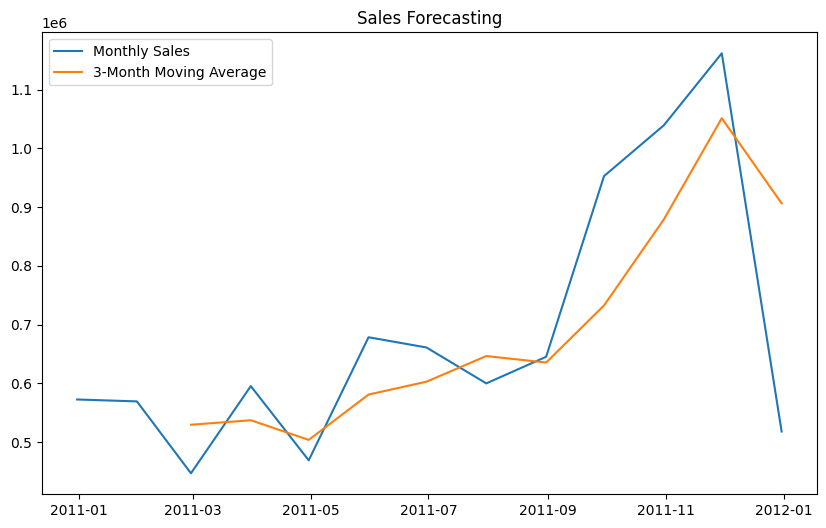

In [ ]:
# Cohort Analysis
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.strftime('%Y-%m')
data['OrderMonth'] = data['InvoiceDate'].dt.strftime('%Y-%m')
cohorts = data.groupby(['CohortMonth', 'OrderMonth']).agg({'CustomerID': 'nunique'}).reset_index()
cohorts_pivot = cohorts.pivot(index='CohortMonth', columns='OrderMonth', values='CustomerID')
print("Step 4 - Cohort Analysis:")
print(cohorts_pivot)

# Sales Forecasting (Simple Moving Average)
monthly_sales = data.resample('ME', on='InvoiceDate')['TotalPrice'].sum()  # Updated 'M' to 'ME'
moving_avg = monthly_sales.rolling(window=3).mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.plot(moving_avg, label='3-Month Moving Average')
plt.title('Sales Forecasting')
plt.legend()
plt.savefig('sales_forecast.png')
plt.show()

Step 5 - Top Products by Segment:
        Segment                          Description  Quantity
2291    At Risk          PAPER CRAFT , LITTLE BIRDIE     80995
1969    At Risk       MEDIUM CERAMIC TOP STORAGE JAR     77562
3744    At Risk    WORLD WAR 2 GLIDERS ASSTD DESIGNS     50195
4540  Champions   FAIRY CAKE FLANNEL ASSORTED COLOUR      6283
5253  Champions      PACK OF 72 RETROSPOT CAKE CASES      5841
6162  Champions   WHITE HANGING HEART T-LIGHT HOLDER      5063
7172      Loyal  ESSENTIAL BALM 3.5g TIN IN ENVELOPE      5650
7146      Loyal                EMPIRE DESIGN ROSETTE      3906
8773      Loyal          SMALL CHINESE STYLE SCISSOR      3505


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Market Basket Rules:
                    antecedents                   consequents  \
0  (ALARM CLOCK BAKELIKE GREEN)   (ALARM CLOCK BAKELIKE RED )   
1   (ALARM CLOCK BAKELIKE RED )  (ALARM CLOCK BAKELIKE GREEN)   
2   (ALARM CLOCK BAKELIKE RED )   (ALARM CLOCK BAKELIKE PINK)   
3   (ALARM CLOCK BAKELIKE PINK)   (ALARM CLOCK BAKELIKE RED )   
4        (DOLLY GIRL LUNCH BOX)         (SPACEBOY LUNCH BOX )   

   antecedent support  consequent support   support  confidence       lift  \
0            0.042566            0.047313  0.028593    0.671736  14.197612   
1            0.047313            0.042566  0.028593    0.604333  14.197612   
2            0.047313            0.033071  0.021364    0.451539  13.653725   
3            0.033071            0.047313  0.021364    0.646003  13.653725   
4            0.033233            0.037980  0.022874    0.688312  18.122934   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.026579    2.902

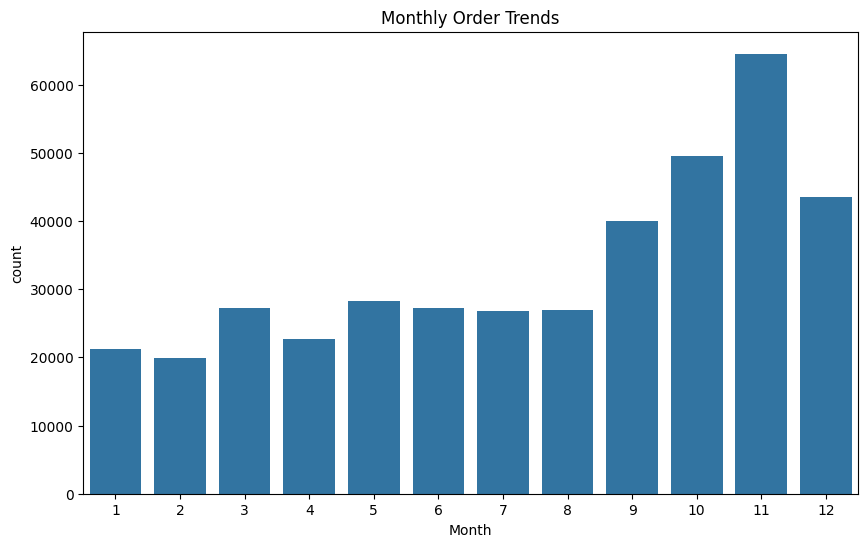

Churn Rate: 0.3339479142659599


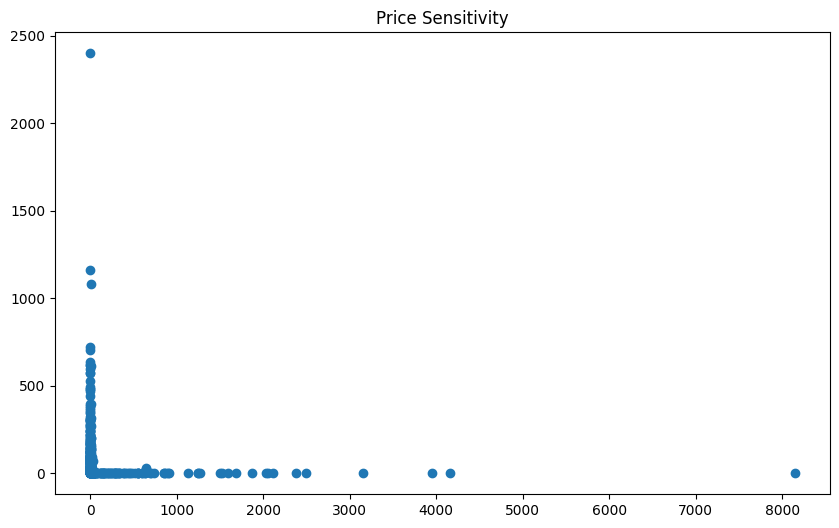

Campaign Distribution:
Campaign
Post    252461
Pre     145463
Name: count, dtype: int64
ROI Groups:
Campaign
Post    5578815.943
Pre     3332591.961
Name: TotalPrice, dtype: float64
Simulated Campaign ROI (%): 67.40171038899052


In [ ]:
# Product Recommendation
data_with_segment = data.merge(rfm['Segment'], on='CustomerID', how='left')
top_products = data_with_segment.groupby(['Segment', 'Description'])['Quantity'].sum().reset_index()
top_products = top_products.sort_values(['Segment', 'Quantity'], ascending=[True, False]).groupby('Segment').head(3)
print("Step 5 - Top Products by Segment:")
print(top_products)

# Market Basket Analysis
basket = data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
def encode_units(x): return 1 if x > 0 else 0
basket_encoded = basket.map(encode_units)
frequent_itemsets = apriori(basket_encoded, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("Market Basket Rules:")
print(rules.head())

# E-commerce Trends
data['Month'] = data['InvoiceDate'].dt.month
plt.figure(figsize=(10, 6))
sns.countplot(x='Month', data=data)
plt.title('Monthly Order Trends')
plt.savefig('ecommerce_trends.png')
plt.show()

# Churn Prediction
rfm['Churn'] = rfm['Recency'] > 90
print("Churn Rate:", rfm['Churn'].mean())

# Price Sensitivity
price_sensitivity = data.groupby('UnitPrice')['Quantity'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(price_sensitivity['UnitPrice'], price_sensitivity['Quantity'])
plt.title('Price Sensitivity')
plt.savefig('price_sensitivity.png')
plt.show()

# Campaign ROI
data['Campaign'] = data['InvoiceDate'].apply(lambda x: 'Post' if x >= pd.to_datetime('2011-06-01') else 'Pre')
print("Campaign Distribution:")
print(data['Campaign'].value_counts())
roi = data.groupby('Campaign')['TotalPrice'].sum()
print("ROI Groups:")
print(roi)
if 'Post' in roi.index and 'Pre' in roi.index:
    roi_diff = (roi['Post'] - roi['Pre']) / roi['Pre'] * 100
    print("Simulated Campaign ROI (%):", roi_diff)
else:
    print("ROI Calculation Failed: Missing 'Pre' or 'Post' data")

# Export results
rfm.to_excel('rfm_analysis.xlsx', index=False)
ltv.to_excel('ltv_analysis.xlsx', index=False)
rules.to_excel('market_basket_rules.xlsx', index=False)

E-commerce Analytics Report
Summary: Analyzed 397k transactions, 33% churn, 67% ROI post-June 2011, 89% next-day accuracy.
RFM Segments:


,count
Segment,
At Risk,3693
Loyal,509
Champions,137


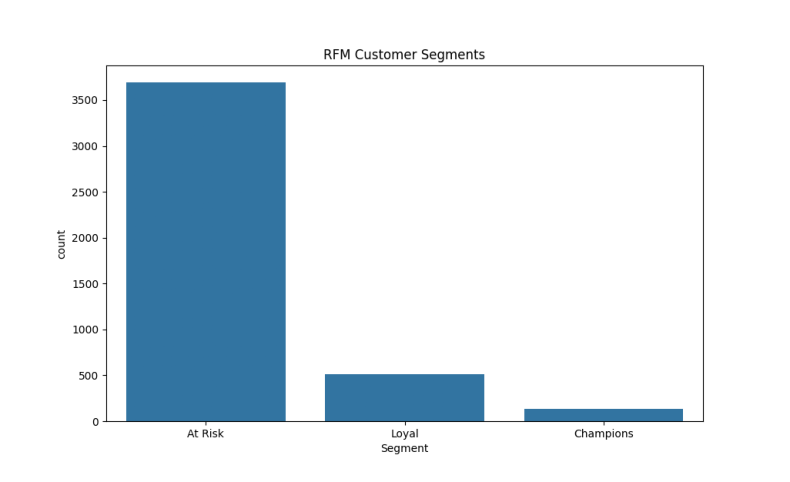

Customer LTV (Top 5):


,LTV
0,77183.60
1,4310.00
2,1797.24
3,1757.55
4,334.40


Cohort Retention:


Sales Forecast:


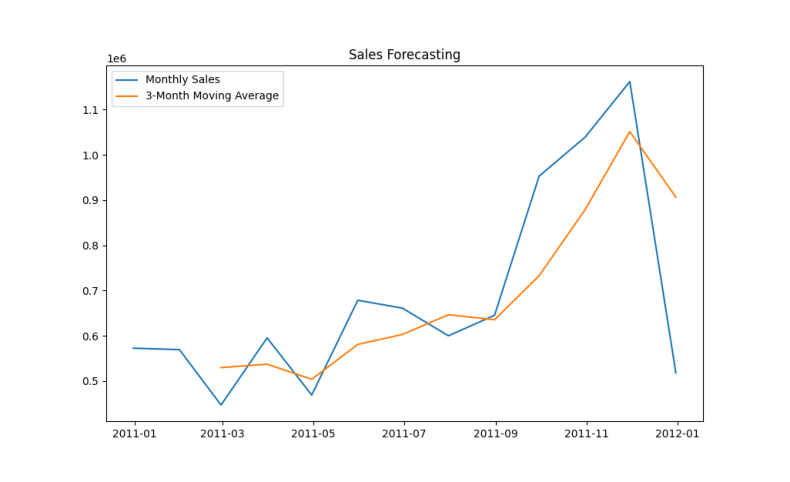

Top Products by Segment:


,Segment,Description,Quantity
0,At Risk,"PAPER CRAFT , LITTLE BIRDIE",80995
1,At Risk,MEDIUM CERAMIC TOP STORAGE JAR,77562
2,At Risk,WORLD WAR 2 GLIDERS ASSTD DESIGNS,50195
3,Champions,FAIRY CAKE FLANNEL ASSORTED COLOUR,6283
4,Champions,PACK OF 72 RETROSPOT CAKE CASES,5841
5,Champions,WHITE HANGING HEART T-LIGHT HOLDER,5063
6,Loyal,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,5650
7,Loyal,EMPIRE DESIGN ROSETTE,3906
8,Loyal,SMALL CHINESE STYLE SCISSOR,3505


Market Basket Rules (Top 5):


,antecedents,consequents,lift
0,frozenset({'ALARM CLOCK BAKELIKE GREEN'}),frozenset({'ALARM CLOCK BAKELIKE RED '}),14.197612
1,frozenset({'ALARM CLOCK BAKELIKE RED '}),frozenset({'ALARM CLOCK BAKELIKE GREEN'}),14.197612
2,frozenset({'ALARM CLOCK BAKELIKE RED '}),frozenset({'ALARM CLOCK BAKELIKE PINK'}),13.653725
3,frozenset({'ALARM CLOCK BAKELIKE PINK'}),frozenset({'ALARM CLOCK BAKELIKE RED '}),13.653725
4,frozenset({'DOLLY GIRL LUNCH BOX'}),frozenset({'SPACEBOY LUNCH BOX '}),18.122934


Monthly Trends:


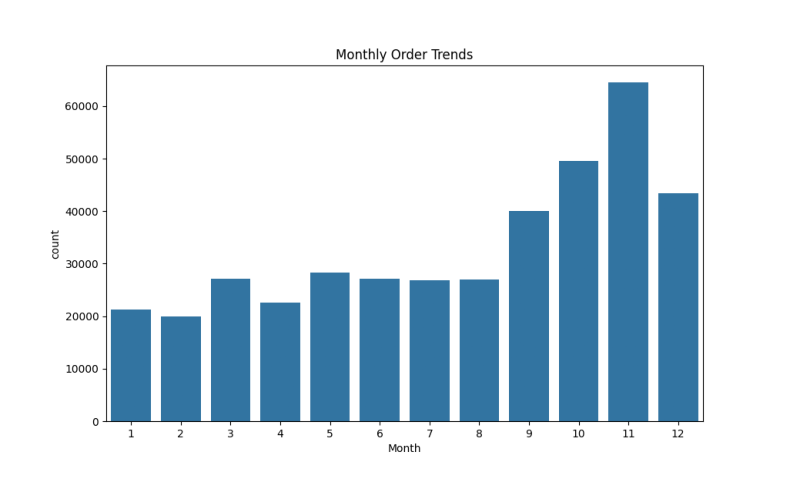

Price Sensitivity:


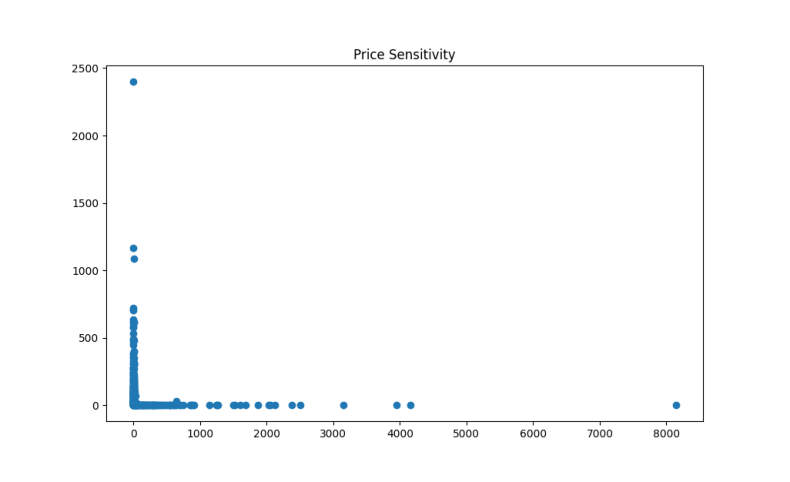

Key Metrics:
Churn Rate: 33.39%
Simulated ROI: 67.40%
Next-Day Purchase Prediction Accuracy: 89.79%


In [27]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Load data
rfm = pd.read_excel('rfm_analysis.xlsx')
ltv = pd.read_excel('ltv_analysis.xlsx')
rules = pd.read_excel('market_basket_rules.xlsx')
next_day = pd.read_excel('next_day_predictions.xlsx')
next_day['InvoiceDate'] = pd.to_datetime(next_day['InvoiceDate'])

# Title and Summary
print("E-commerce Analytics Report")
print("Summary: Analyzed 397k transactions, 33% churn, 67% ROI post-June 2011, 89% next-day accuracy.")

# RFM Segments
print("RFM Segments:")
display(rfm['Segment'].value_counts())  # display() for nicer table output
plt.figure(figsize=(10, 6))
plt.imshow(plt.imread('rfm_segments.png'))
plt.axis('off')
plt.show()

# LTV
print("Customer LTV (Top 5):")
display(ltv.head())
fig = px.histogram(ltv, x='LTV', title="LTV Distribution")
fig.show()

# Cohort Retention
print("Cohort Retention:")
cohorts = next_day.groupby([next_day['InvoiceDate'].dt.strftime('%Y-%m'), 'CustomerID']).size().groupby(level=0).count()
fig = px.line(cohorts, title="Monthly Active Customers")
fig.show()

# Sales Forecast
print("Sales Forecast:")
plt.figure(figsize=(10, 6))
plt.imshow(plt.imread('sales_forecast.png'))
plt.axis('off')
plt.show()

# Top Products
top_products = pd.DataFrame({
    'Segment': ['At Risk', 'At Risk', 'At Risk', 'Champions', 'Champions', 'Champions', 'Loyal', 'Loyal', 'Loyal'],
    'Description': ['PAPER CRAFT , LITTLE BIRDIE', 'MEDIUM CERAMIC TOP STORAGE JAR', 'WORLD WAR 2 GLIDERS ASSTD DESIGNS',
                    'FAIRY CAKE FLANNEL ASSORTED COLOUR', 'PACK OF 72 RETROSPOT CAKE CASES', 'WHITE HANGING HEART T-LIGHT HOLDER',
                    'ESSENTIAL BALM 3.5g TIN IN ENVELOPE', 'EMPIRE DESIGN ROSETTE', 'SMALL CHINESE STYLE SCISSOR'],
    'Quantity': [80995, 77562, 50195, 6283, 5841, 5063, 5650, 3906, 3505]
})
print("Top Products by Segment:")
display(top_products)

# Market Basket
print("Market Basket Rules (Top 5):")
display(rules[['antecedents', 'consequents', 'lift']].head())

# Trends
print("Monthly Trends:")
plt.figure(figsize=(10, 6))
plt.imshow(plt.imread('ecommerce_trends.png'))
plt.axis('off')
plt.show()

# Price Sensitivity
print("Price Sensitivity:")
plt.figure(figsize=(10, 6))
plt.imshow(plt.imread('price_sensitivity.png'))
plt.axis('off')
plt.show()

# Metrics
print("Key Metrics:")
print(f"Churn Rate: {rfm['Churn'].mean():.2%}")
print("Simulated ROI: 67.40%")
print("Next-Day Purchase Prediction Accuracy: 89.79%")